# PCP case study
## No chl prime

### Notebook helper function for pretty output

In [1]:
from IPython.display import Markdown, display


def print_md(markdown_printable):
    """Pretty render Markdown."""
    display(Markdown(str(markdown_printable)))


def print_yaml_file(file_path):
    """Pretty render yaml file."""
    with open(file_path) as f:
        print_md(f"```yaml\n{f.read()}\n```")

### Plotting functions ([`pyglotaran_extras`](https://github.com/s-weigand/pyglotaran-extras/commit/20da3593105fb839f86e668dc12dc9ca87c3b9ce) + `matplotlib`)

In [2]:
import matplotlib.pyplot as plt
from pyglotaran_extras.plotting.plot_overview import plot_overview
from pyglotaran_extras.plotting.plot_svd import plot_svd
from pyglotaran_extras.plotting.style import PlotStyle

plot_style = PlotStyle()
plt.rc("axes", prop_cycle=plot_style.cycler)
plt.rcParams["figure.figsize"] = (10, 7)

### Analysis functions

In [3]:
from glotaran.analysis.optimize import optimize
from glotaran.io import load_dataset, load_model, load_parameters
from glotaran.project.scheme import Scheme

### Read data

In [4]:
dataset = load_dataset("PCP490.ascii")
dataset

<xarray.Dataset>
Dimensions:                      (left_singular_value_index: 127, right_singular_value_index: 127, singular_value_index: 127, spectral: 127, time: 198)
Coordinates:
  * time                         (time) float64 -0.825 -0.725 ... 76.7 78.7
  * spectral                     (spectral) float64 473.2 475.3 ... 743.2 745.3
Dimensions without coordinates: left_singular_value_index, right_singular_value_index, singular_value_index
Data variables:
    data                         (time, spectral) float64 0.0002336 ... 0.000...
    data_left_singular_vectors   (time, left_singular_value_index) float64 -0...
    data_singular_values         (singular_value_index) float64 0.7069 ... 0....
    data_right_singular_vectors  (right_singular_value_index, spectral) float64 ...

## Investigating the original data

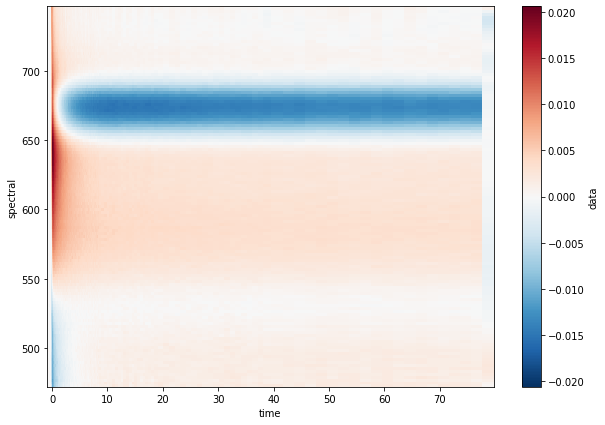

In [5]:
dataset.data.plot(x="time", y="spectral")

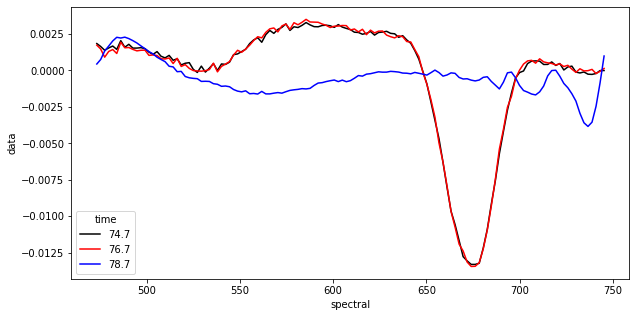

In [6]:
last_traces = dataset.data.isel(
    time=slice(-3, None),
)
last_traces.plot.line(x="spectral", aspect=2, size=5)

As can be seen in the two plots above, the last spectral value appears to be erroneous and thus should be removed from the dataset.

## Removing data
To remove data in an index based manner the `isel` method together with `slice` can be used on the `Dataset` to select only the wanted data and the resulting `Dataset` can be assigned to a new variable.
The keywords in `isel` are the names of the axes that the selection should be applied on and `slice` is the index based selection interval.

### `slice` usage examples
```python
slice(-i)
```
will select all but the last `i` values
```python
slice(i)
```
will select all values up to `i`
```python
slice(i, None)
```
will select all values from index `i` until the end
```python
slice(i, j)
```
will select all values from index `i` until index `j`

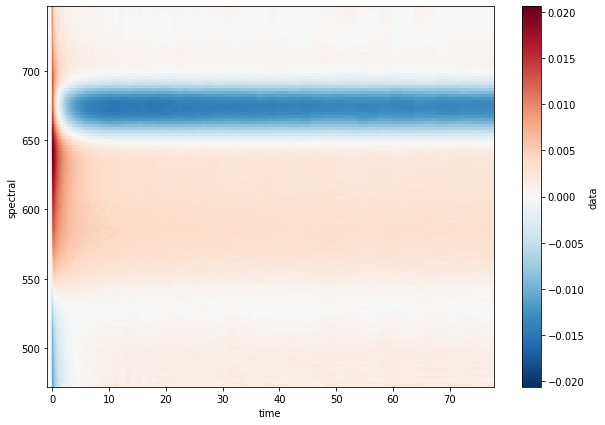

In [7]:
dataset_cleaned = dataset.isel(time=slice(-1))  # drop the last spectral values
dataset_cleaned.data.plot(x="time", y="spectral")

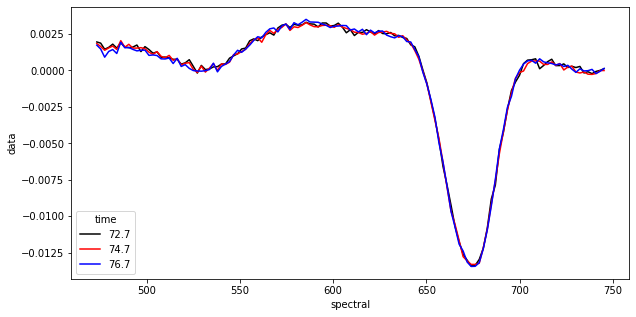

In [8]:
last_traces = dataset_cleaned.data.isel(
    time=slice(-3, None),
)
last_traces.plot.line(x="spectral", aspect=2, size=5)

## None linear time axis
To understand why the heatmap of the data appears to be unevenly spaced we can have a look at the time axis's values over their index.

Text(0, 0.5, 'times value (ns)')

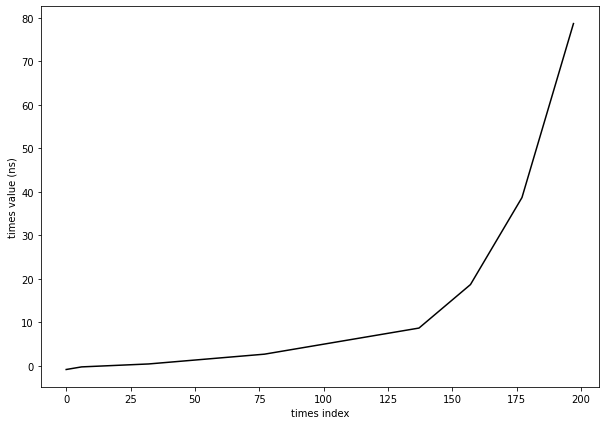

In [9]:
import numpy as np

plt.plot(np.arange(len(dataset.time)), dataset.time)
plt.xlabel("times index")
plt.ylabel("times value (ns)")

The exponential values of the times long their index explains the "mistery" of the unevenly spaced heatmap.

### Load model and parameters

In [10]:
PCP_model = load_model("models/PCP-model.yml")
PCP_parameters = load_parameters("models/PCP-parameters.yml")
print_md(PCP_model.validate(parameters=PCP_parameters))

Your model is valid.

In [11]:
print_md(PCP_model)

# Model

_Type_: kinetic-spectrum

## Initial Concentration

* **input1**:
  * *Label*: input1
  * *Compartments*: ['s1', 's2', 's3', 's4', 's5']
  * *Parameters*: [input.1, input.0, input.0, input.0, input.0]
  * *Exclude From Normalize*: []

## K Matrix

* **km1**:
  * *Label*: km1
  * *Matrix*: 
    * *('s1', 's1')*: kinetic.9
    * *('s2', 's1')*: kinetic.1
    * *('s5', 's1')*: kinetic.2
    * *('s2', 's2')*: kinetic.9
    * *('s3', 's2')*: kinetic.3
    * *('s4', 's2')*: kinetic.4
    * *('s5', 's2')*: kinetic.8
    * *('s3', 's3')*: kinetic.9
    * *('s5', 's3')*: kinetic.5
    * *('s4', 's4')*: kinetic.9
    * *('s5', 's4')*: kinetic.6
    * *('s5', 's5')*: kinetic.7
  

## Irf

* **irf1** (gaussian):
  * *Label*: irf1
  * *Type*: gaussian
  * *Center*: irf.center
  * *Width*: irf.width
  * *Normalize*: True
  * *Backsweep*: False

## Dataset

* **dataset1**:
  * *Label*: dataset1
  * *Megacomplex*: ['mc1']
  * *Initial Concentration*: input1
  * *Irf*: irf1

## Megacomplex

* **mc1**:
  * *Label*: mc1
  * *K Matrix*: ['km1']



### Create scheme and optimize it

In [12]:
PCP_scheme = Scheme(PCP_model, PCP_parameters, {"dataset1": dataset_cleaned})
PCP_result = optimize(PCP_scheme)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.2376e-04                                    3.59e-02    
       1              2         5.5506e-04      3.69e-04       1.57e-02       4.15e-03    
       2              3         5.4022e-04      1.48e-05       6.52e-03       8.85e-04    
       3              4         5.3898e-04      1.23e-06       2.03e-03       2.55e-04    
       4              5         5.3889e-04      9.12e-08       5.50e-04       6.87e-05    
       5              6         5.3889e-04      6.64e-09       1.49e-04       1.85e-05    
       6              7         5.3889e-04      4.81e-10       4.00e-05       4.98e-06    
       7              8         5.3889e-04      3.48e-11       1.08e-05       1.34e-06    
       8              9         5.3889e-04      2.52e-12       2.89e-06       3.60e-07    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 9.2376e-04

In [13]:
PCP_result.data["dataset1"]

<xarray.Dataset>
Dimensions:                                   (clp_label: 5, component: 5, from_species: 5, left_singular_value_index: 127, right_singular_value_index: 127, singular_value_index: 127, species: 5, spectral: 127, time: 197, to_species: 5)
Coordinates:
  * time                                      (time) float64 -0.825 ... 76.7
  * spectral                                  (spectral) float64 473.2 ... 745.3
  * clp_label                                 (clp_label) <U2 's1' 's2' ... 's5'
  * species                                   (species) <U2 's1' 's2' ... 's5'
    rate                                      (component) float64 -15.14 ... ...
    lifetime                                  (component) float64 -0.06605 .....
  * to_species                                (to_species) <U2 's1' ... 's5'
  * from_species                              (from_species) <U2 's1' ... 's5'
Dimensions without coordinates: component, left_singular_value_index, right_singular_value_index, singular_value_index
Data variables: (12/24)
    data                                      (time, spectral) float64 0.0002...
    data_left_singular_vectors                (time, left_singular_value_index) float64 ...
    data_singular_values                      (singular_value_index) float64 ...
    data_right_singular_vectors               (right_singular_value_index, spectral) float64 ...
    matrix                                    (time, clp_label) float64 1.259...
    clp                                       (spectral, clp_label) float64 -...
    ...                                        ...
    a_matrix                                  (component, species) float64 1....
    k_matrix                                  (to_species, from_species) float64 ...
    k_matrix_reduced                          (to_species, from_species) float64 ...
    irf_center                                float64 0.009177
    irf_width                                 float64 0.06631
    irf                                       (time) float64 4.309e-35 ... 0.0
Attributes:
    root_mean_square_error:           0.0002075526312040566
    weighted_root_mean_square_error:  0.0002075526312040566

### Result plots

In [14]:
PCP_result.data["dataset1"]

<xarray.Dataset>
Dimensions:                                   (clp_label: 5, component: 5, from_species: 5, left_singular_value_index: 127, right_singular_value_index: 127, singular_value_index: 127, species: 5, spectral: 127, time: 197, to_species: 5)
Coordinates:
  * time                                      (time) float64 -0.825 ... 76.7
  * spectral                                  (spectral) float64 473.2 ... 745.3
  * clp_label                                 (clp_label) <U2 's1' 's2' ... 's5'
  * species                                   (species) <U2 's1' 's2' ... 's5'
    rate                                      (component) float64 -15.14 ... ...
    lifetime                                  (component) float64 -0.06605 .....
  * to_species                                (to_species) <U2 's1' ... 's5'
  * from_species                              (from_species) <U2 's1' ... 's5'
Dimensions without coordinates: component, left_singular_value_index, right_singular_value_index, singular_value_index
Data variables: (12/24)
    data                                      (time, spectral) float64 0.0002...
    data_left_singular_vectors                (time, left_singular_value_index) float64 ...
    data_singular_values                      (singular_value_index) float64 ...
    data_right_singular_vectors               (right_singular_value_index, spectral) float64 ...
    matrix                                    (time, clp_label) float64 1.259...
    clp                                       (spectral, clp_label) float64 -...
    ...                                        ...
    a_matrix                                  (component, species) float64 1....
    k_matrix                                  (to_species, from_species) float64 ...
    k_matrix_reduced                          (to_species, from_species) float64 ...
    irf_center                                float64 0.009177
    irf_width                                 float64 0.06631
    irf                                       (time) float64 4.309e-35 ... 0.0
Attributes:
    root_mean_square_error:           0.0002075526312040566
    weighted_root_mean_square_error:  0.0002075526312040566

In [17]:
%load_ext line_profiler

ModuleNotFoundError: No module named 'line_profiler._line_profiler'

In [16]:
%lprun

Object `%lprun` not found.


In [18]:
!pip freeze

absolufy-imports==0.3.0
alabaster==0.7.12
anyio==2.1.0
appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
aquirdturtle-collapsible-headings==3.0.1
argon2-cffi==20.1.0
aspy.refactor-imports==2.1.1
asteval==0.9.23
astpretty @ file:///home/conda/feedstock_root/build_artifacts/astpretty_1593607690983/work
astroid==2.5.1
async-generator==1.10
atomicwrites==1.4.0
attrs==20.3.0
Babel==2.9.0
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
black @ file:///home/conda/feedstock_root/build_artifacts/black-recipe_1599478779128/work
bleach==3.2.1
bump2version==1.0.1
cached-property==1.5.2
certifi==2020.11.8
cffi==1.14.4
cfgv==3.2.0
cftime==1.3.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.6.0
colorama @ file:///home/conda/feedstock_root/build_artifacts/colorama_1602866480661/work
coverage==5.3
cycler==0.10.0
darglint==1.6.0
dask==2.30.0
decopatch==1.4.8
decorator==4.4.2
defusedxml==0.6.0


In [ ]:
fig = plot_overview(PCP_result.data["dataset1"], linlog=False)

As can be seen in the above plot (compared to the original one), cleaning the dataset only influenced the residual and SVD's of the residual and data, but not the SAS and DAS.

In [ ]:
print_md(PCP_result.optimized_parameters)

## chl prime

### Load model and parameters
Compared to the full data with the erroneous values for `time==78.7` the scaling of the flow to chl prime needed to be changed
from
```yaml
scaling:
  - [0.75, {vary: false}]
  - [0.25, {vary: false}]
```
to
```yaml
scaling:
  - [0.80, {vary: false}]
  - [0.20, {vary: false}]
```
in order to counter the bleaching.

In [ ]:
PCP_chl_prime_model = load_model("models/PCP-chl-prime-model.yml")
PCP_chl_prime_parameters = load_parameters(
    "models/PCP-chl-prime-parameters-sliced-data.yml"
)
print_md(PCP_model.validate(parameters=PCP_chl_prime_parameters))

In [ ]:
print_md(PCP_chl_prime_model)

### Create sceme and optimize it

In [ ]:
PCP_chl_prime_scheme = Scheme(
    PCP_chl_prime_model, PCP_chl_prime_parameters, {"dataset1": dataset_cleaned}
)
PCP_chl_prime_result = optimize(PCP_chl_prime_scheme)

In [ ]:
PCP_chl_prime_result.data["dataset1"]

### Result plots

In [ ]:
%lprun fig = plot_overview(PCP_chl_prime_result.data["dataset1"], linlog=False)

In [ ]:
print_md(PCP_chl_prime_result.optimized_parameters)